# Analyzing NYC High School Data

## Introduction

In this project, we'll aim to explore relationships between SAT scores and demographic factors in New York City public schools. The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. We will use  the following data sets in this analysis:
- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

### Summary of results

After analyzing the data, we reached that the SAT scores are determining by some of the demographic factors. we can highlight the following facts:
- The safe schools present better results in this test, since a safe place is better for a learning environment.
- The schools with high percentege of white and asian students achieve better results than the ones who present high percentege of black and hipanic students. 
- The gender does not present high influence in the SAT score results.

### Exploring the data

In [1]:
# Read in the data
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# Read in the surveys
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\diana\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


## Cleaning and Transforming datasets

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

The dataframe combined contains all of the data we'll be using in our analysis.

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations 

There are several fields in combined that originally came from a survey of parents, teachers, and students. Let's find correlations between these files and sat_score.

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


Text(0.5,0,'Surveys Fields')

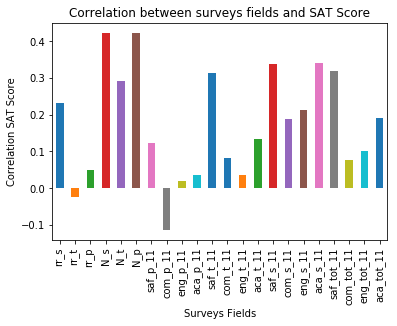

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
correlations[survey_fields].plot.bar()
plt.title('Correlation between surveys fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Surveys Fields')

There are high correletaion between sat_score and the attributes N_s, N_p, N_t that represents the number of students respondents, parents respondents and total teacher respondents, respectively.

The academic expectations score based on student responses or aca_s_11 correlates with sat_score. However, how teachers and parents perceive academic standards, or aca_p_11 and aca_t_11 present a weak correlation with sat_score.

It is interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

There are a high correlation between sat_score and the attributes related to safety anserwed by students and teachers (saf_s_11, saf_t_11), since a safe place is better for a learning environment. For this reason, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

## Exploring safety

Text(0.5,1,'Safety Score anserwed by students vs SAT score')

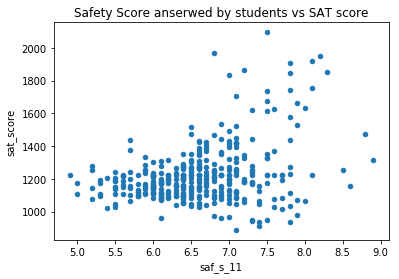

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.title('Safety Score anserwed by students vs SAT score')

This figure shows how saf_s_11 quite correlates with sat_score. There are a few schools with low safety scores and low SAT scores. Notice how for safety score higher than 7.0 the sat_score's values start to increase. There are not schools with a safety score lower than 6.5 that present an average SAT score higher than 1500. Then, the safe schools present better results in this test.

Let's map out safety scores. To do so, we will compute the average safety score for each district and create a map that shows safety scores by district.

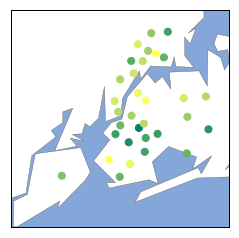

In [13]:
from mpl_toolkits.basemap import Basemap

#compute average safety score for each district
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

# create a map that shows safety scores

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

We will determine whether there are any racial differences in SAT performance by plotting out the correlations between these columns and sat_score

Text(0.5,0,'Percentage of each race')

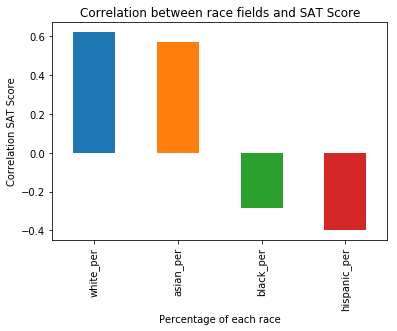

In [14]:
correlations[['white_per', 'asian_per','black_per', 'hispanic_per']].plot.bar()
plt.title('Correlation between race fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Percentage of each race')

There are high positive correlation between the percentage of white and asian students with SAT score. However, the percentage of black (black_per) and hispanic (hispanic_per) students correlate negative with SAT score. A deeper rearch could be done to know why the white and asian students achieve better results than the black and hipanic ones.

Let's explore schools with low SAT scores and high values for hispanic_per

Text(0.5,1,'Percentage of hispanic vs SAT score')

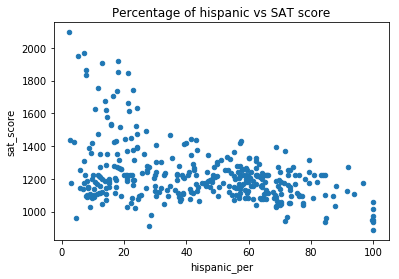

In [15]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.title('Percentage of hispanic vs SAT score')


We can see how when the percentage of hispanic students increase the SAT score values decreace.

In [16]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The students from these schools are immigrants recently arrived from Spanish speaking countries, many of them are learning English, which would explain the lower SAT scores.

In [17]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are specialized schools that offer tuition-free accelerated academics to city residents, and only admit students who pass an entrance exam. It does explain why their students tend to do better SAT scores.

## Gender differences in SAT scores

There are two columns that indicate the percentage of each gender at a school: male_per, female_per
We can plot out the correlations between each percentage and sat_score.

Text(0.5,0,'Percentage of each gender')

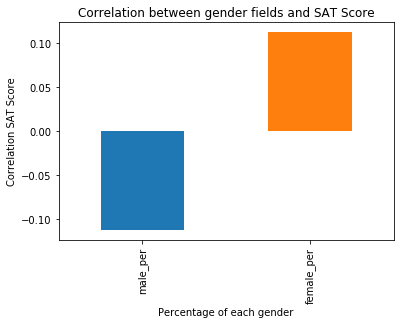

In [18]:
correlations[['male_per', 'female_per']].plot.bar()
plt.title('Correlation between gender fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Percentage of each gender')

Both attributes present a weak correlation with SAT score. However, notice how a high percentage of male at high scholls negatively correlate with SAT score, whereas the percentage of female positively correlate with SAT score.

Text(0.5,1,'Percentage of female vs SAT score')

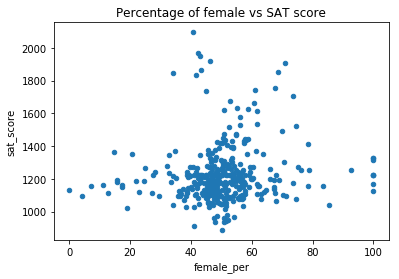

In [19]:
# schools with high SAT scores and a high female_per
combined.plot.scatter("female_per", "sat_score")
plt.title('Percentage of female vs SAT score')

In the plot above, we can see a cluster with many schools with a percentage of female between 40 and 60 and SAT score between 1100 and 1500. However, there are many schools with a high percentage of females and high SAT scores. The correlation doesn't seem to be strong between these attributes.

In [20]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The list above are specialiced schools that seems to be very selective, with academic standards. For example, the first one allows the students to begin their college studies two years early, graduating with a Bard Collage Associate in Arts degree in addition to their high school diploma.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. We'll look at the percentage of students in each school who took at least one AP exam.

## AP Exam Scores vs SAT Scores

Text(0.5,1,'Percentage of students who took AP exams vs SAT score')

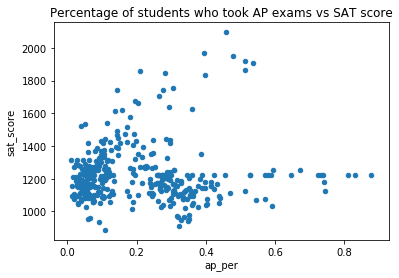

In [21]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter("ap_per", "sat_score")
plt.title('Percentage of students who took AP exams vs SAT score')

Based on the scatterplot, there doesn't seem to be an strong correlation between sat_score and ap_per. However, there is a cluster of schools with a low percentage of students that took at least one AP exam and low SAT scores.

## Conclusion

In this project, we explored relationships between SAT scores and demographic factors in New York City public schools. We can reach that safe schools present higher SAT scores than the unsafe ones. The schools with high percentege of white and asian students achieve better results than the ones who present high percentege of black and hipanic students. A deeper rearch could be done to know why the white and asian students achieve better results than the black and hipanic ones. The gender does not present high influence in the SAT score results. Finally, there doesn't seem to be an strong relation between SAT score and the number of students at a school who took AP exams.

